In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
import datetime as dt

metrics_path = '../metrics/'
figure_path = 'figures/'

def get_filenames_in_folder(path):
    file_names = [join(path, f) for f in listdir(path) if isfile(join(path, f)) and f.lower().endswith('.csv')]
    file_names.sort()
    return file_names

all_files = get_filenames_in_folder(metrics_path)
print(all_files)

def read_file(path):
    return pd.read_csv(path, comment='#')

if len(all_files) > 0:
    latest_data = read_file(all_files[0])
    print(latest_data.iloc[1])

['../metrics/2025-07-09_09-52-21_metrics.csv']
timestamp    2025-07-09T09:51:59+00:00
field                   fragments_sent
value                              0.0
node                            node_0
Name: 1, dtype: object


[0.001      0.00242978 0.00590384 0.01434503 0.03485528 0.0846907
 0.20577986 0.5       ]
8
[232.0, 311.266831, 412.718073, 483.0, 518.0, 538.588575, 568.0, 571.630259]


/tmp/ipykernel_3630/1425409807.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


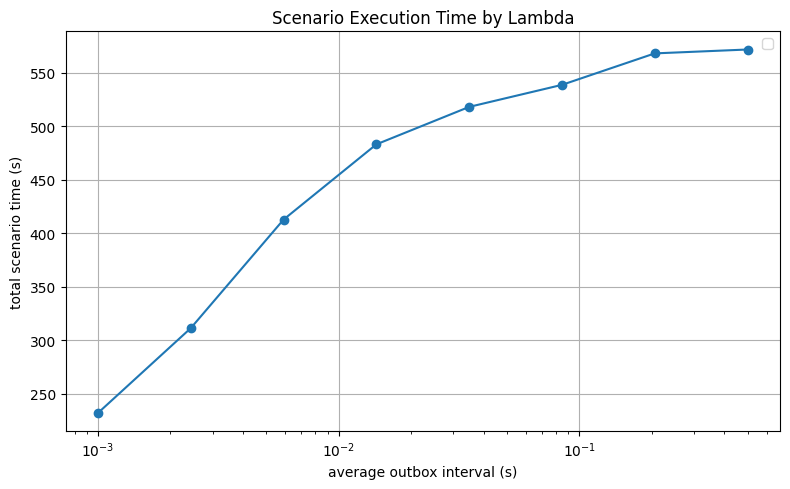

In [14]:
# Time per scenario
# 10 rounds
# y: time per whole scenario
# x: delay in seconds

lambdas = np.logspace(np.log10(0.001), np.log10(0.5), num=8)
print(lambdas)

rt_files = get_filenames_in_folder(join(metrics_path, "run_time"))

def deserizalize_time(str_time):
    return dt.datetime.fromisoformat(str_time)

def get_duration(df, max_prop):
    start = df['timestamp'].iloc[1]
    filtered_df = df.loc[df['field'] == max_prop]
    filtered_df_sorted = filtered_df.sort_values(by=['value', 'timestamp'], ascending=[False, True])
    row = filtered_df_sorted.iloc[0]

    end = row['timestamp']

    return (deserizalize_time(end) - deserizalize_time(start)).total_seconds()

df_rt_files = [read_file(f) for f in rt_files]
rt_list = [get_duration(df, 'fragments_received') for df in df_rt_files]
print(len(rt_list))
print(rt_list)

plt.figure(figsize=(8, 5))           # Optional: set figure size
plt.plot(lambdas[:len(rt_list)], rt_list, marker='o')

# Add labels and title
plt.xlabel('average outbox interval (s)')
plt.xscale('log')
plt.ylabel('total scenario time (s)')
plt.title('Scenario Execution Time by Lambda')

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig(join(figure_path, "time-per-scenario.png"))
plt.show()
